<a href="https://colab.research.google.com/github/iyoob-utexas/ds4e/blob/main/notebooks/n3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

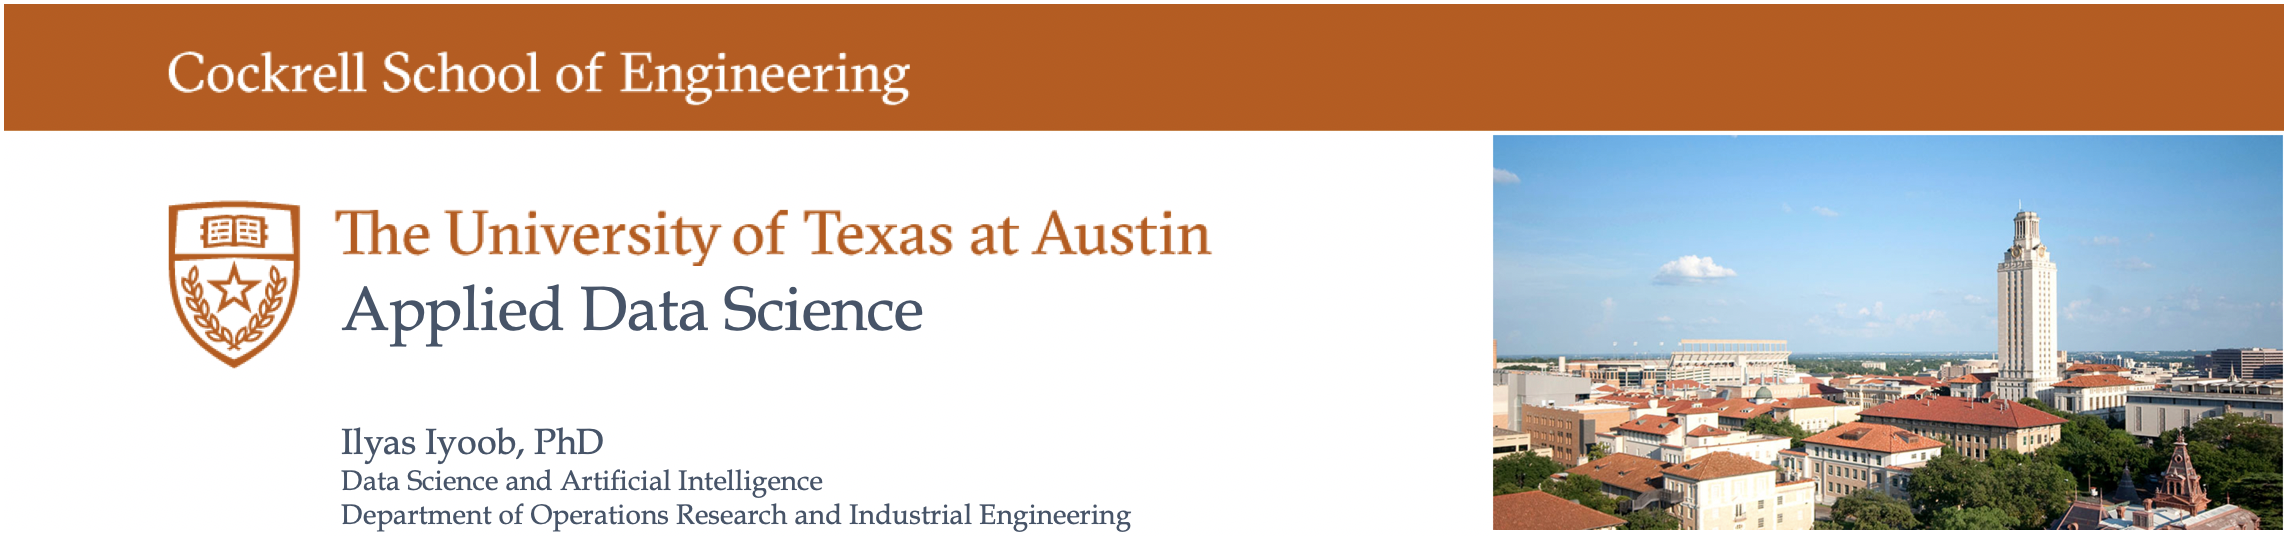

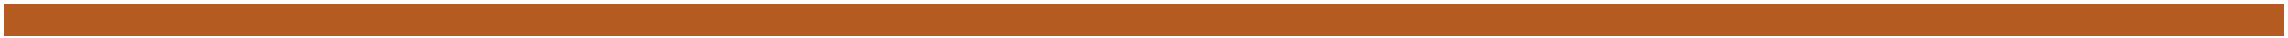

## <font color='#475468'> Melbourne House Prices:</font> 
### <font color='#475468'> Can you leverage more columns in the data set for better predictions?</font> 

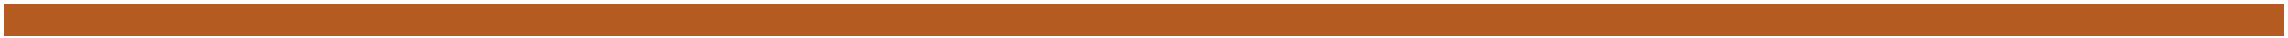

## Initialize

In [1]:
import pandas as pd
import numpy as np

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Load Data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
dfMlb = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/housing/house_prices.csv')

# Select target as a series and features as dataframe
y = dfMlb.loc[:,['Price']].values.ravel()
X = dfMlb.drop(['Price'],axis=1)

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.8, test_size=0.2,random_state=1)

## Build Random Forest Model

In [4]:
from sklearn.ensemble import RandomForestRegressor

# Function for building and scoring Random Forest models
def get_random_forest_mae(X_trn, X_tst, y_trn, y_tst):
    mdlRfsMlb = RandomForestRegressor(random_state=1)
    mdlRfsMlb.fit(X_trn, y_trn)
    y_tst_prd = mdlRfsMlb.predict(X_tst)
    mae = mean_absolute_error(y_tst, y_tst_prd)
    return (mae)

Let's try to build a model with all the features...

In [5]:
# Try to build a model using all features
get_random_forest_mae(X_train, X_test, y_train, y_test)

ValueError: ignored

Seems like some of the columns are non-numeric.  So, how many different types of data exists?

WHITEBOARD >>

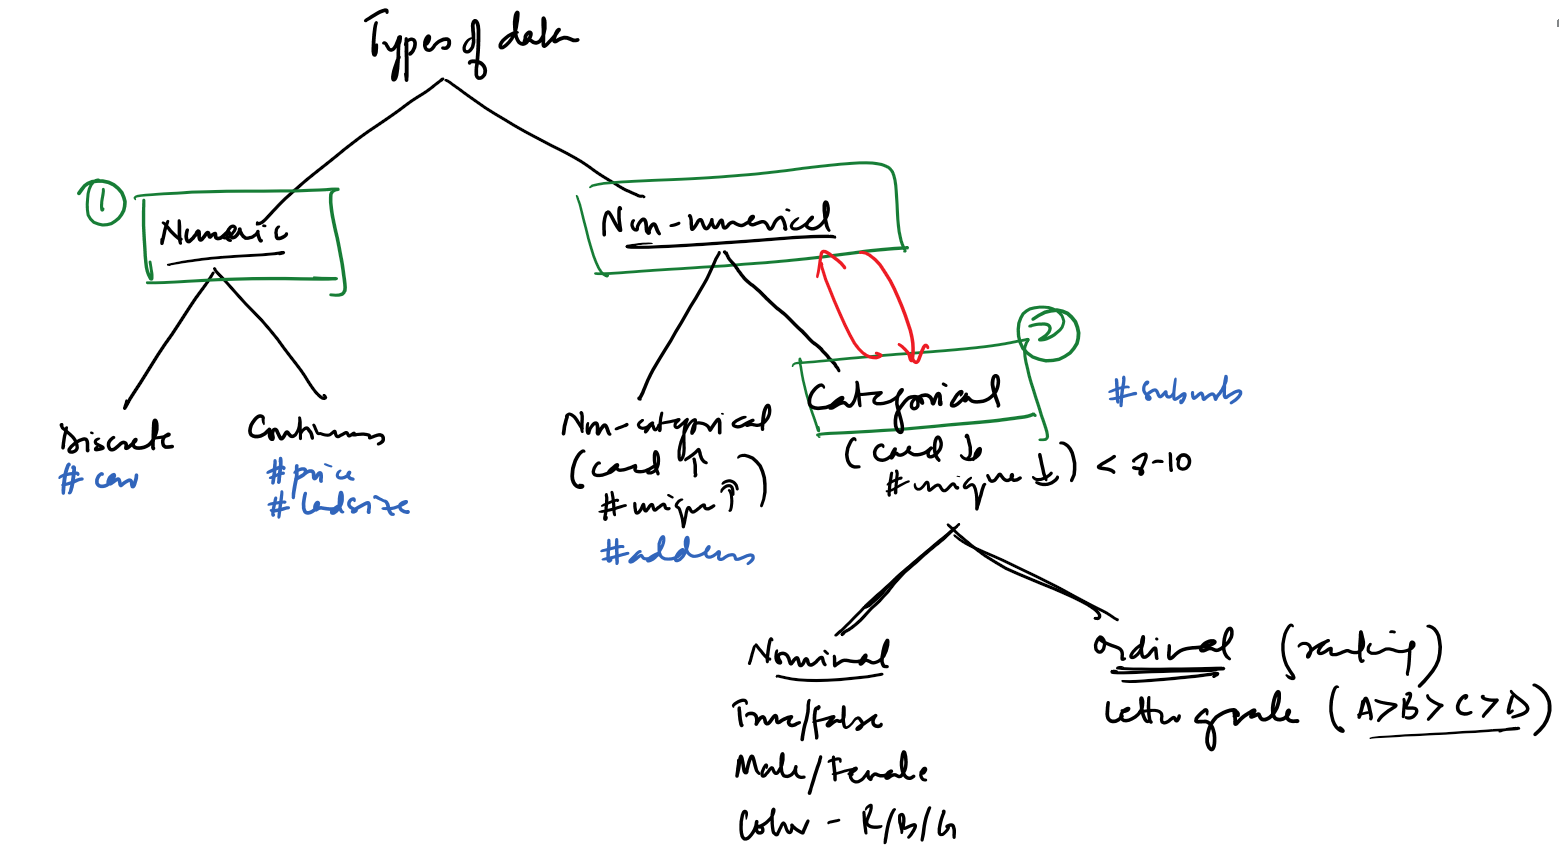

<< WHITEBOARD

## Numerical Features
Columns with quantitative data - either Discrete or Continuous are called Numerical Features.

In [6]:
# Select numeric features
cols_num = [col for col in X.columns if X[col].dtype in ['int64', 'float64']]
Xnum = X[cols_num]

# Split numeric features into training and test sets
Xnum_train, Xnum_test, y_train, y_test = train_test_split(Xnum,y,train_size=0.8, test_size=0.2,random_state=1)

In [7]:
# Try to build a model using all numeric features
get_random_forest_mae(Xnum_train, Xnum_test, y_train, y_test)

ValueError: ignored

Seems like some of the numeric columns have **Missing Values**.

In [8]:
# Count number of missing values in each column of the training data
Xnum_train.isna().sum()

Rooms               0
Distance            0
Postcode            0
Bedroom2            0
Bathroom            0
Car                52
Landsize            0
BuildingArea     5193
YearBuilt        4312
Lattitude           0
Longtitude          0
Propertycount       0
dtype: int64

As expected, there are some missing values.  Let's see how to deal with it...

WHITEBOARD >>

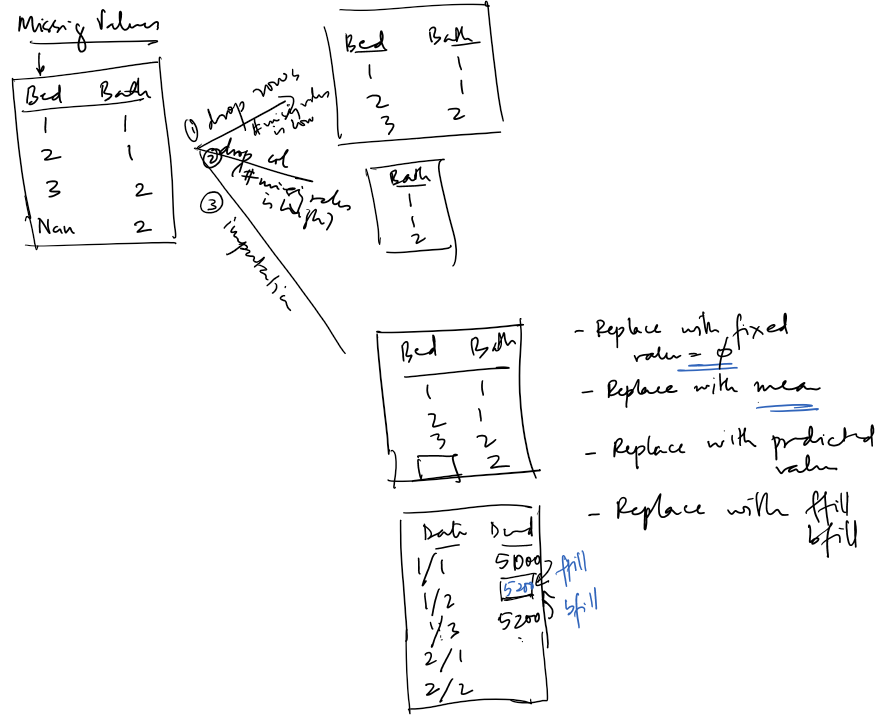

<< WHITEBOARD

#### Approach 1. Drop columns with missing values
The simplest option is to **drop columns** with missing values.

Unless most values in the dropped columns are missing, the model loses access to a lot of (potentially useful!) information with this approach. As an extreme example, consider a dataset with 10,000 rows, where one important column is missing a single entry. This approach would drop the column entirely!

In [9]:
# Identify columns with missing values and then drop such columns
cols_num_null = [col for col in Xnum_train.columns
    if Xnum_train[col].isnull().any()]
Xnum_train_drpnull = Xnum_train.drop(cols_num_null, axis=1)
Xnum_test_drpnull = Xnum_test.drop(cols_num_null, axis=1)

In [10]:
print('MAE from Approach 1 (Drop features with missing values):')
print(get_random_forest_mae(Xnum_train_drpnull, Xnum_test_drpnull, y_train, y_test))

MAE from Approach 1 (Drop features with missing values):
176556.1092096132


Previously, the best MAE we obtained was \$193K, and now we've achieved \$187K by using more numerical features.  Thus the additional numerical features helped even though we completely dropped some of them due to missing values.

#### Approach 2. Fill missing values by Imputation
**Imputation** fills in the missing values with some number. For instance, we can fill in the mean value along each column.

The imputed value won't be exactly right in most cases, but it usually leads to more accurate models than you would get from dropping the column entirely.

In [11]:
# Replace with specific value (0, bfill, ffill)
Xnum_train_repnull = Xnum_train.fillna(method = 'ffill')
Xnum_test_repnull = Xnum_test.fillna(method = 'ffill')

print('MAE from Approach 2 (Replace missing values with forward fill):')
print(get_random_forest_mae(Xnum_train_repnull, Xnum_test_repnull, y_train, y_test))

MAE from Approach 2 (Replace missing values with forward fill):
172541.71958447297


In [12]:
# Replace with mean value
Xnum_train_repnull = Xnum_train.fillna(Xnum_train.mean())
Xnum_test_repnull = Xnum_test.fillna(Xnum_train.mean())

print('MAE from Approach 2 (Replace missing values with mean):')
print(get_random_forest_mae(Xnum_train_repnull, Xnum_test_repnull, y_train, y_test))

MAE from Approach 2 (Replace missing values with mean):
166170.5766405428


Turns out that replacing the missing numerical values with the column mean gives us an MAE of \$175K, which is the best result so far.  This is especially true because the columns with missing values happened to be YearBuilt and BuildingArea, which are understandably important features that drive Sale Price.

In [13]:
# Going forward, let us replace all missing numeric values with the column mean
X_train[cols_num]=Xnum_train_repnull[cols_num]
X_test[cols_num]=Xnum_test_repnull[cols_num]

Next, let's try to improve the model by including some non-numeric features...

utexas_ds_orie_divider_gray.png

## Non-numerical Features

We have already seen the error generated by non-numeric features, but let's try to convert them to numeric values so that they can be used in the model.

In [14]:
# Select non-numeric features
cols_obj = [col for col in X.columns if X[col].dtype == 'object']
cols_obj

['Suburb',
 'Address',
 'Type',
 'Method',
 'SellerG',
 'Date',
 'CouncilArea',
 'Regionname']

In [15]:
# Label encoding on all non-numeric features

from sklearn.preprocessing import LabelEncoder

Xle_train = X_train.copy()
Xle_test = X_test.copy()    
# Apply label encoder to each column with non-numeric data
label_encoder = LabelEncoder()
for col in cols_obj:
    Xle_train[col] = label_encoder.fit_transform(X_train[col])
    Xle_test[col] = label_encoder.transform(X_test[col])

ValueError: ignored

There are too many values to be label encoded.  So, we would need to take only those non-numeric features with low cardinality aka **Categorical features**.

In [16]:
# Select categorical features
cols_cat = [col for col in X.columns if X[col].dtype == 'object' and X[col].nunique()<10]
cols_cat

['Type', 'Method', 'Regionname']

In [17]:
# Label encoding on only categorical features

from sklearn.preprocessing import LabelEncoder

Xle_train = X_train.copy()
Xle_test = X_test.copy()    
# Apply label encoder to each column with categorical data
label_encoder = LabelEncoder()
for col in cols_cat:
    Xle_train[col] = label_encoder.fit_transform(X_train[col])
    Xle_test[col] = label_encoder.transform(X_test[col])

In [18]:
# Encode and Build/Score using all Categorical columns

mae = get_random_forest_mae(Xle_train[cols_num + cols_cat], Xle_test[cols_num + cols_cat], y_train, y_test)
print("MAE from Label Encoding all Categorical columns:") 
print(mae)

MAE from Label Encoding all Categorical columns:
156274.91509818358


So, by including the Categorical features, the MAE is further reduced to to \$166K (which translates to 15% off a mean price of \$1.1M), which is by far the best result.

## Build Gradient Boosted Tree Model

So far, we have made predictions with the Random Forest model, which achieves better performance than a single decision tree simply by averaging the predictions of many decision trees.  We refer to the random forest method as an **ensemble method**. By definition, ensemble methods combine the predictions of several models (e.g., several trees, in the case of random forests).

While the Random Forest model is - as the name suggests - "Random", what if consequent decision trees are added to the ensemble in such a way that the loss function (Mean Squared Error) is minimized?  This is what a gradient descent function helps with in the **Gradient Boosting** model.

Note that after the initial iteration decision tree F0, all subsequent iterations predict the error (instead of the target) using smaller decision trees F1, F2, etc. This results in the final prediction being F0 + learning_rate x F1 + learning_rate x F2 etc (where F1, F2 can be positive or negative values)...

WHITEBOARD >>

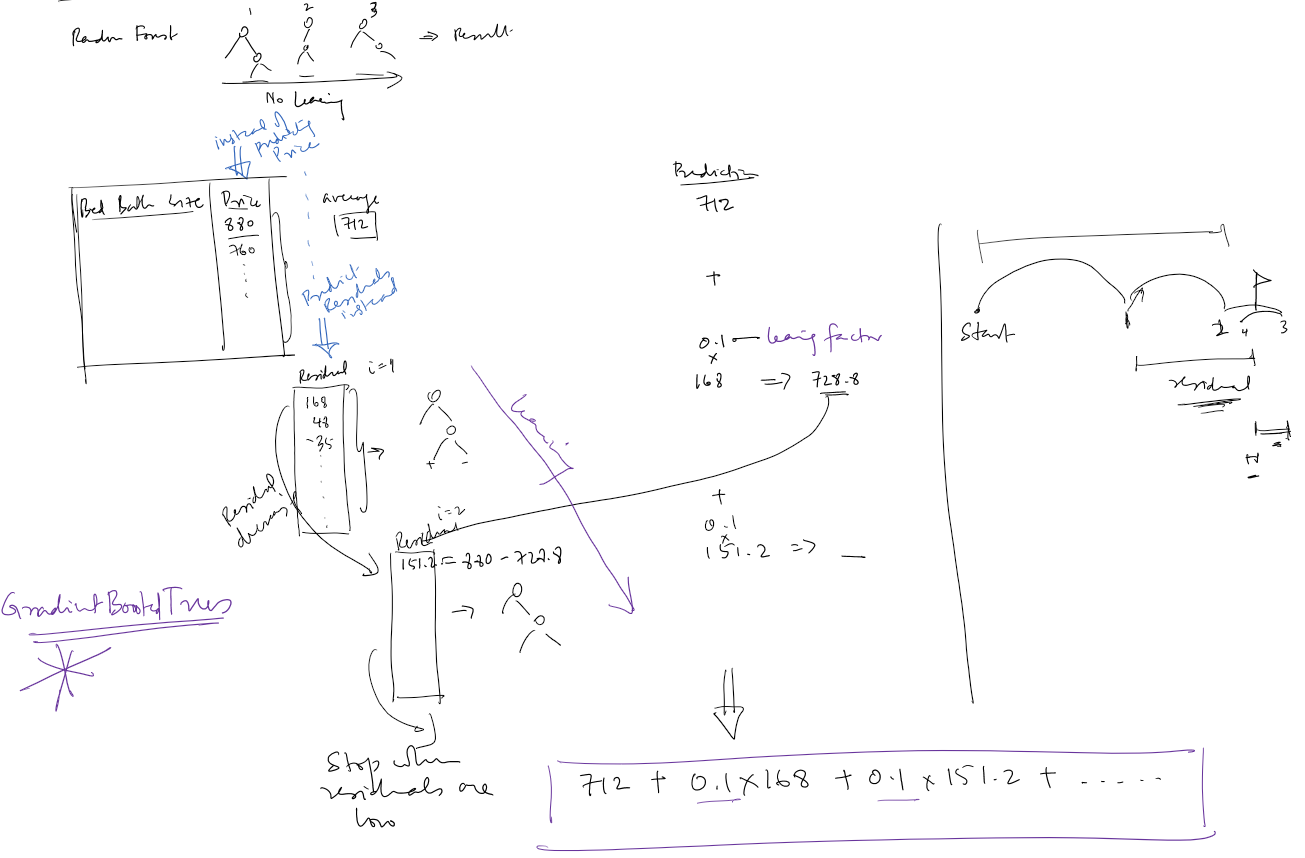

<< WHITEBOARD

Let's begin by training a simple Gradient Boosting model...

In [19]:
from xgboost import XGBRegressor

#Build and score default Gradient Boosting Model
mdlXgbMlb = XGBRegressor()
mdlXgbMlb.fit(Xle_train[cols_num + cols_cat], y_train)
y_test_pred = mdlXgbMlb.predict(Xle_test[cols_num + cols_cat])
mae = mean_absolute_error(y_test_pred, y_test)

print("MAE from default XGBoost model:")
print(mae)

[20:17:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MAE from default XGBoost model:
183775.97442240428


Hold on. The result here is worse than what obtained from our previous Random Forest model.  Let's try to improve this by **tuning the parameters** that drive the Gradient Boosting model.  Below are some popular parameters...

`n_estimators`: maximum number of decision trees that will be ensembled

`max_depth`: maximum depth of each tree (typically 3-10)

`learning_rate`: weight applied to each tree (typically 0.01-0.2)

In [20]:
#Build and score a tuned Gradient Boosting Model
mdlXgbMlb = XGBRegressor(n_estimators=5000, learning_rate=0.01, max_depth=5)
mdlXgbMlb.fit(Xle_train[cols_num + cols_cat], y_train)
y_test_pred = mdlXgbMlb.predict(Xle_test[cols_num + cols_cat])
mae = mean_absolute_error(y_test_pred, y_test)

print("MAE from tuned XGBoost model:")
print(mae)

[20:17:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MAE from tuned XGBoost model:
150992.05709223123


Using a gradient boosted model, we're able to shave off another \$16K off the best MAE so far. Therefore, intelligently selecting trees to add to the ensemble using gradient descent combined with proper parameter tuning helps to significantly improve the result.

## Takeaways

* Expanded the model to include other Numerical features, and replaced missing values by *Imputation*
* Included Categorical features, and converted them to usable information by *Label Encoding*
* Ensembled many decision trees more intelligently using the *Gradient Boosting* model and *Parameter Tuning* for better results

WHITEBOARD >>

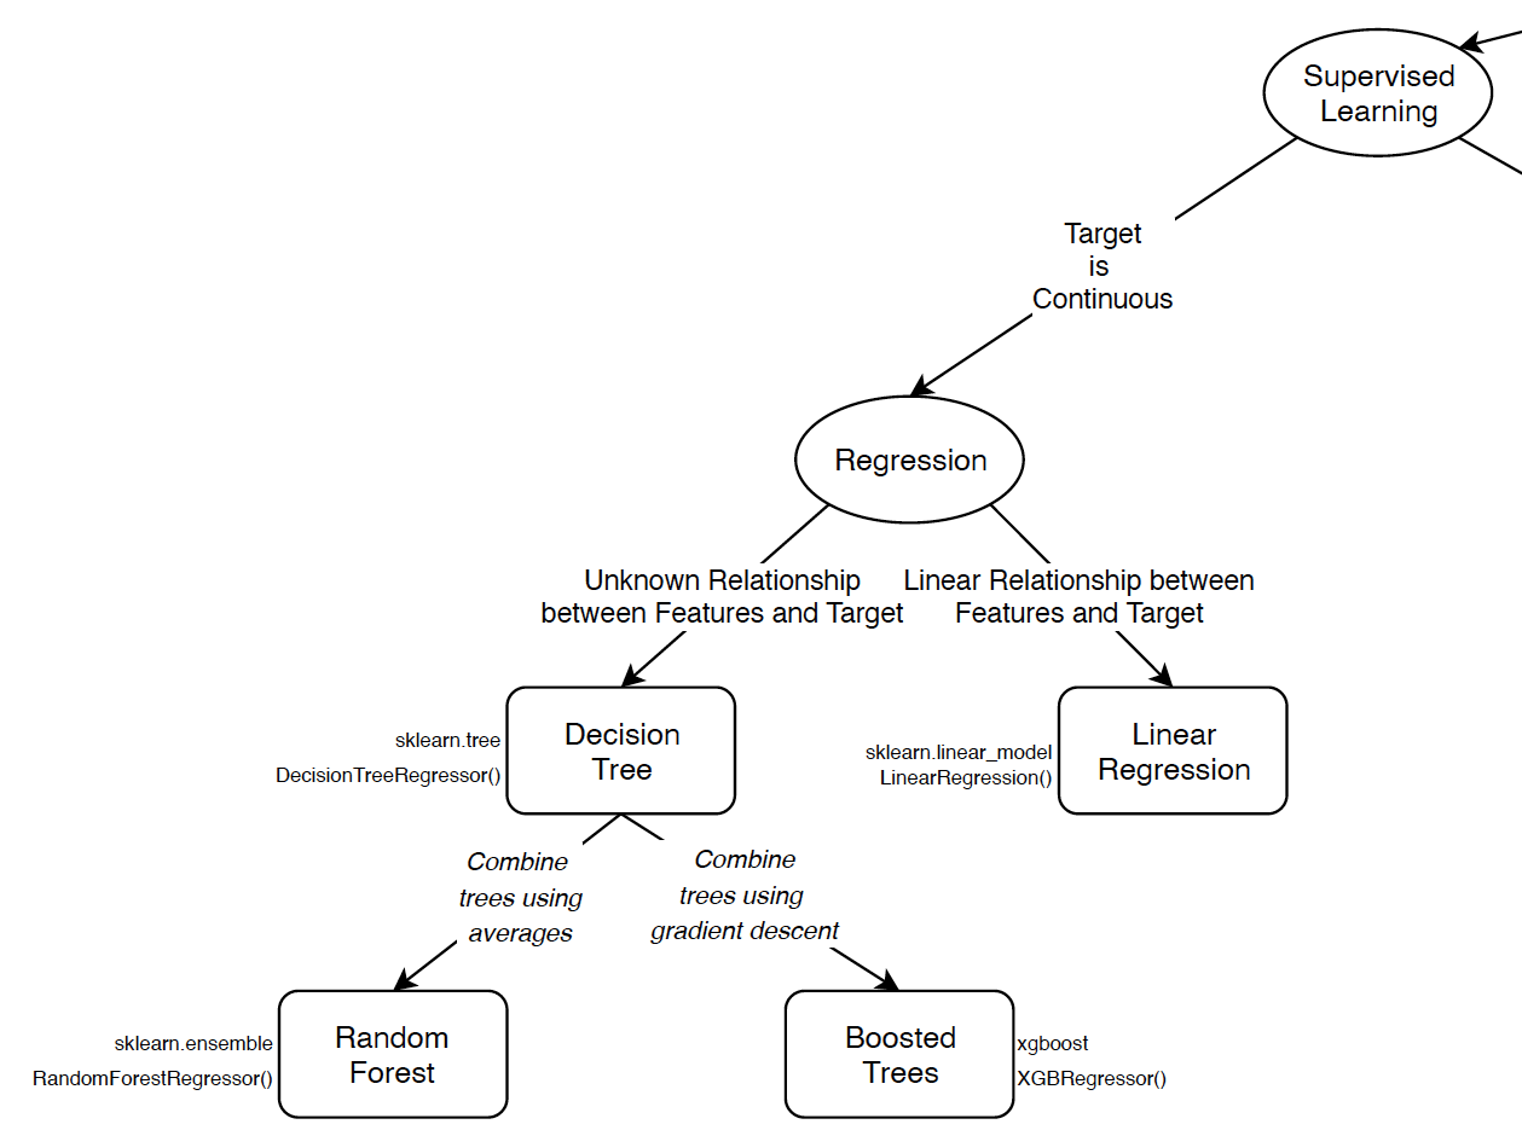

<< WHITEBOARD

utexas_ds_orie_divider_gray.png